<a href="https://colab.research.google.com/github/VictorCampelo/Knowledge-area-classifier-based-on-professional-description/blob/master/Knowledge_area_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install enchant
!pip3 install pyenchant
!pip3 install parfit
# !pip3 install git+https://github.com/BoseCorp/py-googletrans.git --upgrade
# !pip install -U textblob

Reading package lists... Done
Building dependency tree       
Reading state information... Done
enchant is already the newest version (1.6.0-11.1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [2]:
!pip install english-words
from english_words import english_words_set

In [3]:
import warnings
warnings.simplefilter("ignore")

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten, Input, Activation
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, MaxPooling1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam, Nadam
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers      #for l2 regularization

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from tensorflow import keras

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
import nltk
import re
import pandas as pd
import enchant  # pip install pyenchant
eng_dict = enchant.Dict("en_US")
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
from nltk.stem import RSLPStemmer
from graphviz import Source
from collections import Counter
from IPython.display import display
from IPython.display import SVG

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import cross_val_score

In [6]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [7]:
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [8]:
def clean_text(text):

    text = re.sub(r'nan', r' ', text)
    
    regex = r"(([a-z]{1})([0-9]{1}))"
    subst = "\\2 \\3"
    text = re.sub(regex, subst, text, 0, re.MULTILINE)

    regex = r"(([0-9]{1})([a-z]{1}))"
    subst = "\\2 \\3"
    text = re.sub(regex, subst, text, 0, re.MULTILINE)

    regex = r"([a-z])([A-Z])"
    subst = "\\1 \\2"
    text = re.sub(regex, subst, text, 0, re.MULTILINE)
    
    text = text.lower()
    text = re.sub(r'nome', r' ', text)
    text = re.sub(r'empresa', r' ', text)
    text = re.sub(r'emprego', r' ', text)
    text = re.sub(r'período', r' ', text)
    text = re.sub(r'momento', r' ', text)
    text = re.sub(r'duração', r' ', text)
    text = re.sub(r'total', r' ', text)
    text = re.sub(r'duração', r' ', text)
    text = re.sub(r'ano[s]*', r' ', text)
    text = re.sub(r'dia[s]*', r' ', text)
    text = re.sub(r'meses', r' ', text)
    text = re.sub(r'\d+', r' ', text)
    text = re.sub(r"(jan|fev|mar|abr|mai|jun|jul|ago|set|out|nov|dez)", r' ', text)

    regex = r"\W+n"
    subst = " "
    text = re.sub(regex, subst, text, 0, re.MULTILINE)

    regex = r"(\W+|\_)" 
    subst = " "
    text = re.sub(regex, subst, text, 0, re.MULTILINE)
    
    # regex = r"([^aeiou]{3})([^aeiou])"
    # subst = "\\1 \\2"
    # text = re.sub(regex, subst, text, 0, re.MULTILINE)
    
    # regex = r"([^aeiou])([^aeiou]{3})"
    # subst = "\\1 \\2"
    # text = re.sub(regex, subst, text, 0, re.MULTILINE)
    
    regex = r"\s+[^aeiou]\s+"
    subst = " "
    text = re.sub(regex, subst, text, 0, re.MULTILINE)

    regex = r"\s[^aeiou]\s"
    subst = " "
    text = re.sub(regex, subst, text, 0, re.MULTILINE)

    text = re.sub('^\s', '', text)  # remove extra whitespace
    text = re.sub('\s+', ' ', text)  # remove extra whitespace

    return text

def separate_df(df, pct):
    train = pd.DataFrame(dict(text=[], target=[]),  dtype=int)
    test = pd.DataFrame(dict(text=[], target=[]),  dtype=int)
    targets = df.target.unique().tolist()
    for target in targets:
        l = round(len(df[df.target == target]) * pct)
        for (index, line), count in zip(df[df.target == target].iterrows(), 
                                        range(len(df[df.target == target]))):
            if(count <= l):
                train = train.append(dict(text=line.text, target=int(target)), 
                                     ignore_index=True)
            else:
                test = test.append(dict(text=line.text, target=int(target)), 
                                   ignore_index=True)
    return train, test

def RemoveStopWords(sent):
    stp = nltk.corpus.stopwords.words('portuguese')
    listW = ""
    for wrd in sent.split(" "):
        if wrd not in stp:
            listW += str(wrd)+" "
    return listW

def stemming(sent):
    stp = nltk.corpus.stopwords.words('portuguese')
    stemmer = nltk.stem.RSLPStemmer()
    listW = []
    for (desc, value) in sent:
        desc = word_tokenize(desc)
        [desc for char in desc for l in segment_str(char)]
        
        aux = [str(stemmer.stem(p)) for p in desc if p not in stp]
        listW.append((aux, value))
    return listW

def tokenize(sent):
    sent = sent.lower()
    sent = nltk.tokenize.word_tokenize(sent, language='portuguese')
    return sent

def stemmingSimple(sent):
    # stp = nltk.corpus.stopwords.words('portuguese')
    stemmer = RSLPStemmer()
    listS = []
    # print(sent)
    for i, wrd in enumerate(sent):
      listW = []
      for p in wrd.split():
        # if p not in stp:
        stems = stemmer.stem(p.lower())
        listW.append(stems)
      # print(listW)
      listS.append(" ".join(listW))
    # print(listW)
    return listS

def stemmingSimpleSet(sent):
  # stp = nltk.corpus.stopwords.words('portuguese')
  stemmer = RSLPStemmer()
  listS = []
  # print(sent)
  for i, wrd in enumerate(sent):
    listW = []
    for p in wrd.split():
      # if p not in stp:
      stems = stemmer.stem(p.lower())
      listW.append(stems)
    # print(listW)
    listS.append(" ".join(set(listW)))
  # print(listW)
  return listS

def addAllWords(sent):
    words = []
    for (desc, value) in sent:
        words.extend(desc)
    return words

def freqWords(sent):
    wrds = nltk.FreqDist(sent)
    return wrds

def uniqueWords(sent):
    freq = sent.keys()
    return freq

def extractWords(sent):
    doc = set(sent)
    characteristics = {}
    for wdr in u_words_train:
        characteristics['%s' % wdr] = (wdr in doc)
    return characteristics

def makeAcuracy(tree,x_test,y_test):
    predictions = clf.predict(x_test)
    erro = 0.0
    for x in range(len(predictions)):
        if predictions[x] != y_test[x]:
            erro += 1.
    acuracy = (1-(erro/len(predictions)))
    return acuracy

def segment_str(chars, exclude=None):
    words = []

    if not chars.isalpha():  # don't check punctuation etc.; needs more work
        return [chars]

    if not exclude:
        exclude = set()

    working_chars = chars
    while working_chars:
        # iterate through segments of the chars starting with the longest segment possible
        for i in range(len(working_chars), 1, -1):
            segment = working_chars[:i]
            if eng_dict.check(segment) and segment not in exclude:
                words.append(segment)
                working_chars = working_chars[i:]
                break
        else:  # no matching segments were found
            if words:
                exclude.add(words[-1])
                return segment_str(chars, exclude=exclude)
            # let the user know a word was missing from the dictionary,
            # but keep the word
            # print('"{chars}" not in dictionary (so just keeping as one segment)!'
            #       .format(chars=chars))
            return [chars]
    # return a list of words based on the segmentation
    return words

def translator(sent):
  trans_sent = []
  for wrd in sent.split(" "):
    if wrd in dictionary:
      trans_sent.append(dictionary[wrd])
    else:
      trans_sent.append(wrd)
  return " ".join(trans_sent)

def find_english_words(sent):
  trans_sent = []
  for wrd in sent.split(" "):
    if wrd in english_words_set:
      trans_sent.append(wrd)
  return " ".join(trans_sent)
  
  
def models(X_train, Y_train, X_test, Y_test):
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(class_weight='balanced', random_state = 0)
  log.fit(X_train, Y_train)
  log_pred = log.predict(X_test)

  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
  knn.fit(X_train, Y_train)
  knn_pred = knn.predict(X_test)

  from sklearn.svm import SVC
  svc_lin = SVC(kernel='linear', random_state = 0, class_weight='balanced')
  svc_lin.fit(X_train, Y_train)
  svc_lin_pred = svc_lin.predict(X_test)

  from sklearn.svm import SVC
  svc_rbf = SVC(kernel='rbf', random_state = 0)
  svc_rbf.fit(X_train, Y_train)
  svc_rbf_pred = svc_rbf.predict(X_test)

  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, class_weight='balanced')
  tree.fit (X_train, Y_train)
  tree_pred = tree.predict(X_test)

  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(criterion = 'entropy', random_state = 0, class_weight='balanced')
  forest.fit(X_train, Y_train)
  forest_pred = forest.predict(X_test)

  from sklearn.linear_model import Perceptron
  pcp = Perceptron(random_state = 0, class_weight='balanced')
  pcp.fit(X_train, Y_train)
  pcp_pred = pcp.predict(X_test)

  from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
  mnb = MultinomialNB(alpha=.01)
  mnb.fit(X_train, Y_train)
  mnb_pred = mnb.predict(X_test)

  bnb = BernoulliNB(alpha=.01)
  bnb.fit(X_train, Y_train)
  bnb_pred = bnb.predict(X_test)

  cnb = ComplementNB(alpha=.1)
  cnb.fit(X_train, Y_train)
  cnb_pred = cnb.predict(X_test)
  
  from sklearn.linear_model import SGDClassifier
  sgdc = SGDClassifier(random_state = 0, class_weight='balanced')
  sgdc.fit(X_train, Y_train)
  sgdc_pred = sgdc.predict(X_test)

  print('[0]Logistic Regression Training Accuracy: ', log.score(X_train, Y_train))
  print('[0]Logistic Regression Cross_val Accuracy: ', np.mean(cross_val_score(log, X_train, Y_train, cv=10)))
  print('[0]Logistic Regression Testing Accuracy: ', accuracy_score(Y_test, log_pred))
  print(classification_report(Y_test, log_pred))

  # plot_confusion_matrix(log, X_test, Y_test)

  print('[1]KNeighborns Training Accuracy: ', knn.score(X_train, Y_train))
  print('[1]KNeighborns Training Cross_val Accuracy: ', np.mean(cross_val_score(knn, X_train, Y_train, cv=10)))
  print('[1]KNeighborns Testing Accuracy: ', accuracy_score(Y_test, knn_pred))
  print(classification_report(Y_test, knn_pred))

  print('[2]SVC Linear Training Accuracy: ', svc_lin.score(X_train, Y_train))
  print('[2]SVC Linear Training Cross_val Accuracy: ', np.mean(cross_val_score(svc_lin, X_train, Y_train, cv=10)))
  print('[2]SVC Linear Testing Accuracy: ', accuracy_score(Y_test, svc_lin_pred))
  print(classification_report(Y_test, svc_lin_pred))

  print('[3]SVC RBF Training Accuracy: ', svc_rbf.score(X_train, Y_train))
  print('[3]SVC RBF Training Cross_val Accuracy: ', np.mean(cross_val_score(svc_rbf, X_train, Y_train, cv=10)))
  print('[3]SVC RBF Testing Accuracy: ', accuracy_score(Y_test, svc_rbf_pred))
  print(classification_report(Y_test, svc_rbf_pred))

  print('[4]Decision Tree Training Accuracy: ', tree.score(X_train, Y_train))
  print('[4]Decision Tree Training Cross_val Accuracy: ', np.mean(cross_val_score(tree, X_train, Y_train, cv=10)))
  print('[4]Decision Tree Testing Accuracy: ', accuracy_score(Y_test, tree_pred))
  print(classification_report(Y_test, tree_pred))

  print('[5]Random Forest Training Accuracy: ', forest.score(X_train, Y_train))
  print('[5]Random Forest Training Cross_val Accuracy: ', np.mean(cross_val_score(forest, X_train, Y_train, cv=10)))
  print('[5]Random Forest Testing Accuracy: ', accuracy_score(Y_test, forest_pred))
  print(classification_report(Y_test, forest_pred))

  print('[6] Perceptron Training Accuracy: ', pcp.score(X_train, Y_train))
  print('[6] Perceptron Training Cross_val Accuracy: ',  np.mean(cross_val_score(pcp, X_train, Y_train, cv=10)))
  print("[6] Perceptron Testing accuracy: ", accuracy_score(y_test, pcp_pred))
  print(classification_report(Y_test, pcp_pred))

  print('[7] MultinomialNB Training Accuracy: ', mnb.score(X_train, Y_train))
  print('[7] MultinomialNB Training Cross_val Accuracy: ',  np.mean(cross_val_score(mnb, X_train, Y_train, cv=10)))
  print("[7] MultinomialNB Testing accuracy: ", accuracy_score(Y_test, mnb_pred))
  print(classification_report(Y_test, pcp_pred))

  print('[8] BernoulliNB Training Accuracy: ', bnb.score(X_train, Y_train))
  print('[8] BernoulliNB Training Cross_val Accuracy: ',  np.mean(cross_val_score(bnb, X_train, Y_train, cv=10)))
  print("[8] BernoulliNB Testing accuracy: ", accuracy_score(Y_test, bnb_pred))
  print(classification_report(Y_test, pcp_pred))

  print('[9] ComplementNB Training Accuracy: ', cnb.score(X_train, Y_train))
  print('[9] ComplementNB Training Cross_val Accuracy: ',  np.mean(cross_val_score(cnb, X_train, Y_train, cv=10)))
  print("[9] ComplementNB Testing accuracy: ", accuracy_score(Y_test, cnb_pred))
  print(classification_report(Y_test, pcp_pred))

  print('[10] SGDClassifier Training Accuracy: ', sgdc.score(X_train, Y_train))
  print('[10] SGDClassifier Training Cross_val Accuracy: ',  np.mean(cross_val_score(sgdc, X_train, Y_train, cv=10)))
  print("[10] SGDClassifier Testing accuracy: ", accuracy_score(Y_test, sgdc_pred))
  print(classification_report(Y_test, sgdc_pred))

  n_list = [accuracy_score(Y_test, log_pred), accuracy_score(Y_test, knn_pred), 
            accuracy_score(Y_test, svc_lin_pred), accuracy_score(Y_test, svc_rbf_pred),
            accuracy_score(Y_test, forest_pred), accuracy_score(Y_test, pcp_pred),
            accuracy_score(Y_test, mnb_pred), accuracy_score(Y_test, bnb_pred),
            accuracy_score(Y_test, cnb_pred), accuracy_score(Y_test, sgdc_pred)]
  n_max = max(n_list)
  n_pos = n_list.index(n_max)
  models = [log, knn, svc_lin, svc_rbf, tree, forest, pcp, mnb, bnb, cnb, sgdc]
  print(models[n_pos+1])
  return models[n_pos+1]

In [9]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/lkd.csv', error_bad_lines=False)

b'Skipping line 3: expected 11 fields, saw 18\nSkipping line 5: expected 11 fields, saw 36\nSkipping line 45: expected 11 fields, saw 17\nSkipping line 51: expected 11 fields, saw 19\nSkipping line 86: expected 11 fields, saw 12\nSkipping line 171: expected 11 fields, saw 36\nSkipping line 173: expected 11 fields, saw 14\nSkipping line 174: expected 11 fields, saw 18\nSkipping line 185: expected 11 fields, saw 23\nSkipping line 207: expected 11 fields, saw 34\nSkipping line 254: expected 11 fields, saw 12\nSkipping line 258: expected 11 fields, saw 15\nSkipping line 268: expected 11 fields, saw 13\nSkipping line 273: expected 11 fields, saw 77\nSkipping line 274: expected 11 fields, saw 30\nSkipping line 275: expected 11 fields, saw 17\nSkipping line 282: expected 11 fields, saw 18\nSkipping line 291: expected 11 fields, saw 16\nSkipping line 311: expected 11 fields, saw 34\nSkipping line 328: expected 11 fields, saw 12\nSkipping line 362: expected 11 fields, saw 19\nSkipping line 366:

In [10]:
df.isna().sum()

id                0
category          0
sub_category      0
url               0
image_url        25
about           437
experience       95
name             25
title            25
location         25
skills            0
dtype: int64

In [11]:
df.fillna(" ", inplace=True)

In [12]:
df.category.unique()

array(['Administracao', 'Arte e Desing', 'Ciências Biológicas e da Terra',
       'Análise e Desenvolvimento de Sistemas',
       'Ciências Sociais e Humanas', 'Comunicação e Informação',
       'Engenharia e Produção'], dtype=object)

In [13]:
len(df.sub_category.unique())

161

In [14]:
df.columns

Index(['id', 'category', 'sub_category', 'url', 'image_url', 'about',
       'experience', 'name', 'title', 'location', 'skills'],
      dtype='object')

In [15]:
df.drop(columns=['id', 'url', 'image_url', 'name', 'location'], inplace=True)

In [16]:
# df[['about', 'experience', 'title', 'skills']].apply(lambda x : '{} {} {} {}'.format(x[0],x[1], x[2], x[3]), axis=1)

In [17]:
df['text'] = df[['about', 'experience', 'title', 'skills']].apply(
    lambda x : '{} {} {} {}'.format(x[0],x[1], x[2], x[3]), axis=1)
df['target'] = df['category']

df.drop(columns=['about', 'experience', 'title', 'skills'], inplace=True)

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.target.unique().tolist())
le.classes_
df.target = le.transform(df.target)

In [19]:
le.classes_[6]

'Engenharia e Produção'

In [20]:
df_train, df_test = separate_df(df, .90)

In [21]:
print(len(df_train))
print(len(df_test))

1387
147


In [22]:
print(len(df_test.target.unique()))
print(len(df_train.target.unique()))

7
7


In [23]:
df_train.target = df_train.target.astype(int)
df_test.target = df_test.target.astype(int)

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1387 non-null   object
 1   target  1387 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.8+ KB


In [25]:
# df_train

In [26]:
en, pt = [], []
f = open("/content/drive/My Drive/Colab Notebooks/dict.txt", "r")
for line in f.readlines():
  # print(line)
  en.append(line.split(" - ")[0])
  pt.append(line.split(" - ")[1].replace("\n", ""))

dictionary = {}
zip_iterator = zip(en, pt)

dictionary = dict(zip_iterator)
print(len(dictionary))
# dictionary

2918


In [27]:
f = open("/content/drive/My Drive/Colab Notebooks/text_en.txt", "r")
en1 = f.read().split(",")

f = open("/content/drive/My Drive/Colab Notebooks/text_pt.txt", "r")
pt1 = f.read().split(",")

print(len(en1))
print(len(pt1))

en2 = [en.replace(" ", "") for en in en1]
pt2 = [pt.replace(" ", "") for pt in pt1]

en = [en.replace("\n", "") for en in en2]
pt = [pt.replace("\n", "") for pt in pt2]

dictionary2 = {}
zip_iterator = zip(en, pt)

dictionary2 = dict(zip_iterator)
print(len(dictionary2))

dictionary.update(dictionary2)
print(len(dictionary))
# dictionary

2723
2723
1363
4226


In [28]:
for i, row in df_train.iterrows():
  result = translator(RemoveStopWords(clean_text(row['text'])))
  df_train.at[i,'text'] = result

for i, row in df_test.iterrows():
  result = translator(RemoveStopWords(clean_text(row['text'])))
  df_test.at[i,'text'] = result

for i, row in df.iterrows():
  result = translator(RemoveStopWords(clean_text(row['text'])))
  df.at[i,'clear_text'] = result

In [80]:
result = ""
for i, row in df.iterrows():
  result += find_english_words(row['clear_text']) + " "
result.replace("", "")
print()
# print(set(result.split(" ")))
# print(len(set(result.split(" "))))
# print(", ".join(set(result.split(" "))))

In [30]:
fout = "/content/drive/My Drive/Colab Notebooks/dictionary.txt"
fo = open(fout, "w")

for k, v in dictionary.items():
    fo.write(str(k) + ' - '+ str(v) + '\n')

fo.close()

In [31]:
from nltk.corpus import words as englishWords

In [32]:
df_train.to_csv('/content/drive/My Drive/Colab Notebooks/df_train_treated.csv')

In [33]:
df_test.to_csv('/content/drive/My Drive/Colab Notebooks/df_test_treated.csv')

In [34]:
# print(stemmingSimple(df_train['text'])[1])
# print(stemmingSimpleSet(df_train['text'])[1])

In [35]:
# applie stemming in each list
train = stemmingSimpleSet(df_train['text'])
test  = stemmingSimpleSet(df_test['text'])
complet = stemmingSimpleSet(df['clear_text'])

df_train['text_stem'] = train
df_test['text_stem'] = test
df['text_stem'] = complet

In [36]:
# df_train['text_stem']

In [37]:
MAX_SEQ_LEN = int(df['text'].apply(lambda x : len(x.split(' '))).quantile(0.95))
MAX_SEQ_LEN

796

In [38]:
# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(df_train['text_stem'])
train_text_vec = tokenizer.texts_to_sequences(df_train['text_stem'])
test_text_vec = tokenizer.texts_to_sequences(df_test['text_stem'])

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN, padding='post')
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN, padding='post')

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

# print('Sample Tweet Before Processing:', df_train["text"].values[0])
# print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 13582
Max Token Index: 13582 

What the model will interpret: [123, 15, 73, 825, 160, 4225, 149, 1489, 103, 206, 1411, 6085, 1574, 10, 59, 134, 709, 55, 324, 319, 110, 104, 468, 188, 2107, 185, 61, 794, 23, 71, 28, 27, 54, 383, 94, 17, 889, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [39]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(df_train['target'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
cws = class_weight.compute_class_weight('balanced', 
                              np.unique(df_train['target'].values), 
                              df_train['target'].values)
print(cws)
# print(y_train_int)

Distribution of Classes: Counter({6: 349, 0: 217, 4: 187, 3: 178, 5: 165, 2: 147, 1: 144})
[0.91310072 1.37599206 1.34791059 1.11316212 1.05958747 1.2008658
 0.56774458]


In [40]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,6)

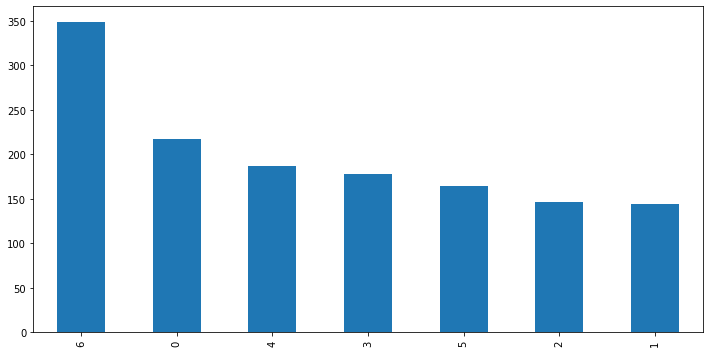

In [41]:
df_train['target'].value_counts().plot(kind='bar')

[38, 27, 42, 91, 60, 80, 168, 128, 3, 3, 3, 8, 51, 88, 11, 100, 54, 124, 4, 2, 4, 5, 2, 7, 3, 9, 3, 116, 121, 48, 94, 31, 80, 28, 128, 128, 13, 28, 89, 56, 95, 32, 39, 39, 201, 36, 38, 11, 260, 29, 77, 165, 88, 33, 116, 32, 86, 69, 38, 32, 21, 20, 219, 77, 73, 24, 15, 13, 17, 197, 5, 163, 153, 10, 14, 115, 53, 32, 70, 184, 117, 17, 26, 29, 0, 68, 36, 82, 93, 37, 54, 158, 42, 43, 161, 33, 55, 38, 284, 11, 84, 20, 82, 5, 233, 5, 11, 3, 3, 8, 5, 4, 2, 4, 9, 45, 0, 24, 20, 129, 210, 202, 115, 100, 87, 250, 85, 34, 82, 22, 132, 172, 110, 107, 168, 159, 64, 6, 92, 230, 70, 499, 70, 181, 201, 177, 18, 159, 31, 35, 47, 7, 7, 7, 8, 7, 71, 151, 155, 71, 6, 92, 31, 79, 115, 27, 30, 17, 34, 108, 82, 153, 21, 113, 190, 232, 32, 122, 216, 198, 141, 184, 37, 161, 213, 193, 161, 173, 127, 221, 259, 111, 103, 20, 73, 72, 202, 157, 4, 91, 138, 40, 97, 98, 42, 21, 66, 80, 49, 34, 7, 5, 7, 7, 11, 5, 34, 4, 7, 27, 26, 110, 37, 47, 103, 92, 22, 45, 151, 66, 18, 88, 167, 34, 78, 147, 101, 43, 24, 150, 22, 16

(array([659., 389., 245., 144.,  66.,  20.,   7.,   2.,   1.,   1.]),
 array([  0. ,  49.9,  99.8, 149.7, 199.6, 249.5, 299.4, 349.3, 399.2,
        449.1, 499. ]),
 <a list of 10 Patch objects>)

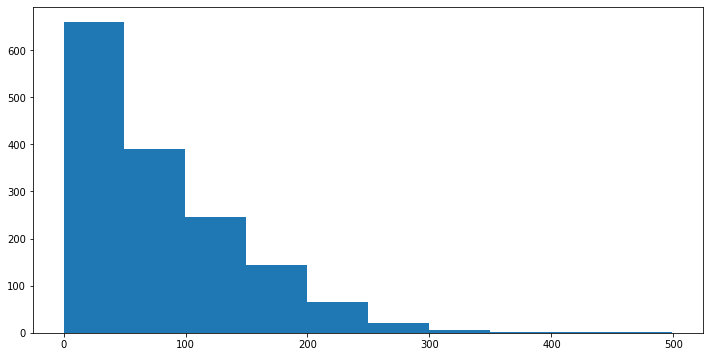

In [42]:
t = [len(tokenize(t)) for t in df['text_stem']]
print(t)
plt.hist(t)

[38, 27, 42, 91, 60, 80, 168, 128, 3, 3, 3, 8, 51, 88, 11, 100, 54, 124, 4, 2, 4, 5, 2, 7, 3, 9, 3, 116, 121, 48, 94, 31, 80, 28, 128, 128, 13, 28, 89, 56, 95, 32, 39, 39, 201, 36, 38, 11, 260, 29, 77, 165, 88, 33, 116, 32, 86, 69, 38, 32, 21, 20, 219, 77, 73, 24, 15, 13, 17, 197, 5, 163, 153, 10, 14, 115, 53, 32, 70, 184, 117, 17, 26, 29, 0, 68, 36, 82, 93, 37, 54, 158, 42, 43, 161, 33, 55, 38, 284, 11, 84, 20, 82, 5, 233, 5, 11, 3, 3, 8, 5, 4, 2, 4, 9, 45, 0, 24, 20, 129, 210, 202, 115, 100, 87, 250, 85, 34, 82, 22, 132, 172, 110, 107, 168, 159, 64, 6, 92, 230, 70, 499, 70, 181, 201, 177, 18, 159, 31, 35, 47, 7, 7, 7, 8, 7, 71, 151, 155, 71, 6, 92, 31, 79, 115, 27, 30, 17, 34, 108, 82, 153, 21, 113, 190, 232, 32, 122, 216, 198, 141, 184, 37, 161, 213, 193, 161, 173, 127, 221, 259, 111, 103, 20, 73, 72, 202, 157, 4, 91, 138, 40, 97, 98, 42, 21, 66, 80, 49, 34, 7, 5, 7, 7, 11, 5, 34, 4, 7, 27, 26, 110, 37, 47, 103, 92, 22, 45, 151, 66, 18, 88, 167, 34, 78, 147, 101, 43, 24, 150, 22, 16

(array([659., 389., 245., 144.,  66.,  20.,   7.,   2.,   1.,   1.]),
 array([  0. ,  49.9,  99.8, 149.7, 199.6, 249.5, 299.4, 349.3, 399.2,
        449.1, 499. ]),
 <a list of 10 Patch objects>)

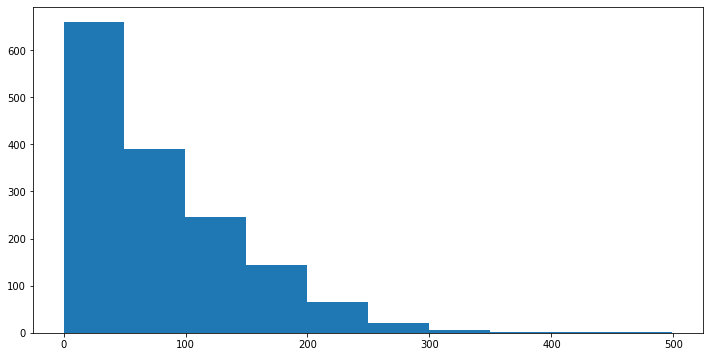

In [43]:
t = [len(set(tokenize(t))) for t in df['text_stem']]
print(t)
plt.hist(t)

In [44]:
# print(df['text_stem'][0])
# print(set(tokenize(df['text_stem'][0])))
# print(len(tokenize(df['text_stem'][0])))
# print(len(set(tokenize(df['text_stem'][0]))))

# Separação dos dados em treino e teste:

In [45]:
sentences_train, sentences_test, y_train, y_test = \
train_test_split(df_train['text_stem'], df_train['target'], test_size=0.25, 
                 random_state=41)

In [46]:
maxlen = 0
for sent in sentences_train:
  maxlen += len(sent)
maxlen = int(maxlen/len(sentences_train))

In [47]:
vectorizer = TfidfVectorizer()
vectorizer.fit(sentences_train)

X_train_tf = vectorizer.transform(sentences_train)
X_test_tf  = vectorizer.transform(sentences_test)

# print(vectorizer.vocabulary_)

In [48]:
num_classes = np.max(y_train) + 1
num_classes

7

In [49]:
y_train_enc = keras.utils.to_categorical(y_train, num_classes)
y_test_enc = keras.utils.to_categorical(y_test, num_classes)

# Modelo simple de Rede Neural utilizando o Keras

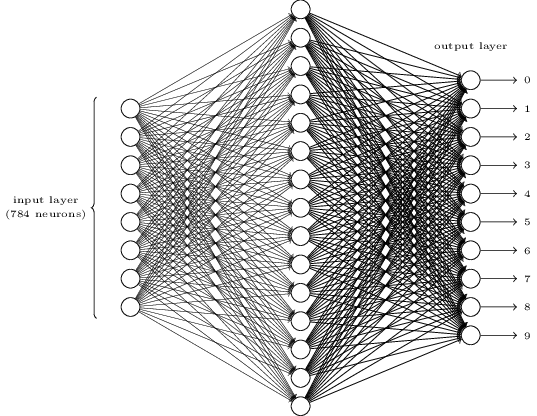

In [50]:
n_layers = 1 
n_densers = 126
learning_rate = 0.001
epochs = 50
batch = 32
activation = 'relu'
opt = Nadam(lr=learning_rate)
model = Sequential()
model.add(layers.Dense(n_densers, input_dim=X_train_tf.shape[1], activation=activation))
for i in range(1):
  model.add(layers.Dense(n_densers,  activation=activation))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer = opt,
              loss = "categorical_crossentropy",
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 126)               1434006   
_________________________________________________________________
dense_1 (Dense)              (None, 126)               16002     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 889       
Total params: 1,450,897
Trainable params: 1,450,897
Non-trainable params: 0
_________________________________________________________________


In [51]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(X_train_tf.toarray(), y_train_enc,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test_tf.toarray(), y_test_enc),
                    batch_size=batch,
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
loss, accuracy = model.evaluate(X_train_tf.toarray(), y_train_enc, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tf.toarray(), y_test_enc, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(history)

Epoch 1/50
33/33 [==============================] - 1s 32ms/step - loss: 1.8843 - accuracy: 0.3154 - val_loss: 1.6924 - val_accuracy: 0.4179
Epoch 2/50
33/33 [==============================] - 1s 28ms/step - loss: 1.2676 - accuracy: 0.7106 - val_loss: 1.0479 - val_accuracy: 0.7233
Epoch 3/50
33/33 [==============================] - 1s 27ms/step - loss: 0.4232 - accuracy: 0.9673 - val_loss: 0.7717 - val_accuracy: 0.7752
Epoch 4/50
33/33 [==============================] - 1s 26ms/step - loss: 0.1269 - accuracy: 0.9923 - val_loss: 0.7044 - val_accuracy: 0.7781
Epoch 5/50
33/33 [==============================] - 1s 26ms/step - loss: 0.0641 - accuracy: 0.9952 - val_loss: 0.6959 - val_accuracy: 0.7839
Epoch 6/50
33/33 [==============================] - 1s 25ms/step - loss: 0.0435 - accuracy: 0.9952 - val_loss: 0.6967 - val_accuracy: 0.7839
Epoch 7/50
33/33 [==============================] - 1s 25ms/step - loss: 0.0358 - accuracy: 0.9942 - val_loss: 0.6992 - val_accuracy: 0.7896
Epoch 8/50
33

In [52]:
test = vectorizer.transform(df_test['text_stem'].values)
for i in range(0, 100, 10):
  prediction = model.predict(test[i].toarray())
  # print(df_test.loc[i, 'text'][:50], "...")
  print('Actual label:' + str(le.classes_[df_test.loc[i, 'target']]))
  print("Predicted label: " + str(le.classes_[np.argmax(prediction)]) + "\n") 

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Administracao

Actual label:Arte e Desing
Predicted label: Arte e Desing

Actual label:Ciências Biológicas e da Terra
Predicted label: Administracao

Actual label:Ciências Biológicas e da Terra
Predicted label: Ciências Biológicas e da Terra

Actual label:Análise e Desenvolvimento de Sistemas
Predicted label: Análise e Desenvolvimento de Sistemas

Actual label:Análise e Desenvolvimento de Sistemas
Predicted label: Comunicação e Informação

Actual label:Ciências Sociais e Humanas
Predicted label: Ciências Sociais e Humanas

Actual label:Ciências Sociais e Humanas
Predicted label: Ciências Sociais e Humanas



## Escolhendo melhores parametros da rede neural simples

In [53]:
input_shape = X_train_tf.shape[1]

In [54]:
def create_model(learning_rate = 0.01, activation = 'relu', n_densers = 100, n_layers = 0):
  opt = Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
  model = Sequential()
  model.add(layers.Dense(n_densers, input_dim=X_train_tf.shape[1], activation=activation))
  for i in range(n_layers):
    model.add(layers.Dense(n_densers,  activation=activation))
  model.add(Dense(7, activation='softmax'))

  model.compile(optimizer = opt,
                loss = "categorical_crossentropy",
                metrics=['accuracy'])
  return model

In [55]:
params = {'activation': ["relu"],
          'batch_size': [16, 32, 64], 
          'epochs': [50],
          'learning_rate': [0.01, 0.001, 0.0001],
          'n_densers': [100, 126, 200, 256],
          'n_layers': [0, 1, 2]
          }

In [56]:
model = KerasClassifier(build_fn = create_model,
                       verbose = 0)

In [57]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params,
                                   cv=10)

In [58]:
grid_result = random_search.fit(X_train_tf.toarray(), 
                                y_train_enc, 
                                validation_data=(X_test_tf.toarray(), y_test_enc), 
                                callbacks=[earlyStopping, mcp_save, reduce_lr_loss])


Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00018: ReduceLROnPlat

In [59]:
print(random_search.best_score_)
print(random_search.best_params_)
# print(random_search.best_estimator_)
# print(random_search.cv_results_)

0.7855769217014312
{'n_layers': 0, 'n_densers': 256, 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 16, 'activation': 'relu'}


In [60]:
print(classification_report(y_test, random_search.best_estimator_.predict(X_test_tf.toarray())))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        45
           1       0.68      0.71      0.70        42
           2       0.78      0.78      0.78        32
           3       0.74      0.71      0.72        41
           4       0.85      0.73      0.78        55
           5       0.65      0.78      0.70        40
           6       0.84      0.85      0.84        92

    accuracy                           0.78       347
   macro avg       0.77      0.77      0.77       347
weighted avg       0.78      0.78      0.78       347



In [61]:
best_model = random_search.best_estimator_

In [62]:
from sklearn.metrics import confusion_matrix

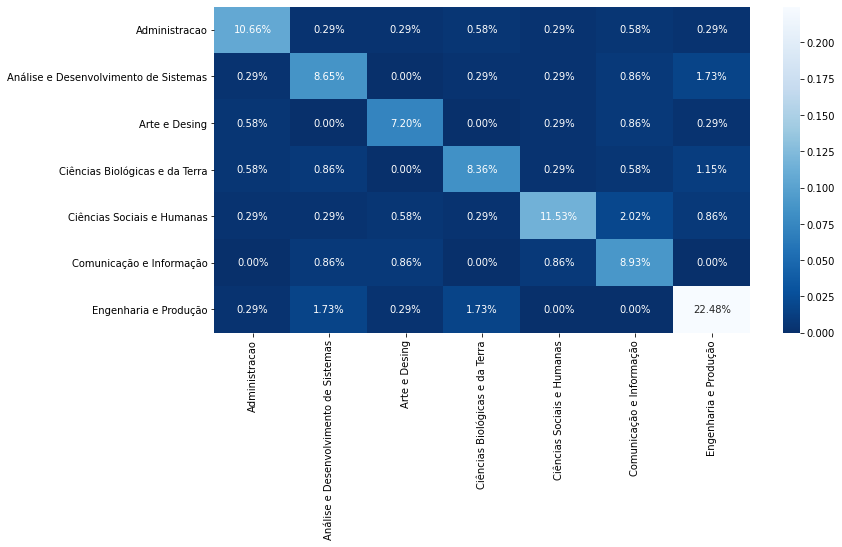

In [63]:
cm = confusion_matrix(y_test, random_search.predict(X_test_tf.toarray()))
# or
#cm = np.array([[1401,    0],[1112, 0]])
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues_r', 
            xticklabels=le.classes_, yticklabels=le.classes_)

# Experimentos: 

In [64]:
# # The maximum number of words to be used. (most frequent)
# MAX_NB_WORDS = 1000
# # Max number of words in each complaint.
# MAX_SEQUENCE_LENGTH = maxlen
# # This is fixed.
# EMBEDDING_DIM = 50

# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(sentences_train)

# X_train = tokenizer.texts_to_sequences(sentences_train)
# X_test = tokenizer.texts_to_sequences(sentences_test)

# vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

# X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
# X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# print(X_train[2, :])

# def RNN():
#   inputs= Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
#   layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)(inputs)
#   # layer = Bidirectional(LSTM(n_densers))(layer)
#   layer = LSTM(126)(layer)
#   layer = Dense(n_densers,name='FC1')(layer)
#   layer = Activation('relu')(layer)
#   layer = Dense(num_classes,name='out_layer')(layer)
#   layer = Activation('softmax')(layer)
#   model = Model(inputs=inputs,outputs=layer)
#   return model

# opt = Nadam(lr=learning_rate)
# model = RNN()
# model.summary()
# model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# history = model.fit(X_train, y_train,
#                     epochs=epochs,
#                     verbose=True,
#                     validation_data=(X_test, y_test),
#                     batch_size=100,
#                     callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
# loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# # plot_history(history)

In [65]:
# vectorizer = CountVectorizer()
# vectorizer.fit(sentences_train)

# X_train_ct = vectorizer.transform(sentences_train)
# X_test_ct  = vectorizer.transform(sentences_test)

# print(vectorizer.vocabulary_)

In [67]:
vectorizer = TfidfVectorizer()
vectorizer.fit(sentences_train)

X_train_tf = vectorizer.transform(sentences_train)
X_test_tf  = vectorizer.transform(sentences_test)

# print(vectorizer.vocabulary_)

## Execusão de varios algoritmos de ML para a escolha do melhor modelo 

In [68]:
mod = models(X_train_tf, y_train, X_test_tf, y_test)

[0]Logistic Regression Training Accuracy:  0.975
[0]Logistic Regression Cross_val Accuracy:  0.7961538461538462
[0]Logistic Regression Testing Accuracy:  0.7780979827089337
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        45
           1       0.76      0.74      0.75        42
           2       0.74      0.88      0.80        32
           3       0.68      0.73      0.71        41
           4       0.87      0.73      0.79        55
           5       0.72      0.78      0.75        40
           6       0.86      0.83      0.84        92

    accuracy                           0.78       347
   macro avg       0.76      0.78      0.77       347
weighted avg       0.78      0.78      0.78       347

[1]KNeighborns Training Accuracy:  0.28846153846153844
[1]KNeighborns Training Cross_val Accuracy:  0.2519230769230769
[1]KNeighborns Testing Accuracy:  0.2622478386167147
              precision    recall  f1-score   support

   

- O modelo que apresentou os melhores resultados foi o Stochastic Gradient Descent (SGD).

## Escolhendo os melhores parâmetros para o Stochastic Gradient Descent (SGD) Classifier

In [69]:
# load libraries
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Create an scaler object
sc = StandardScaler()

# Create a pca object
pca = decomposition.PCA()

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[
                      #  ('sc', sc),
                      #   ('pca', pca),
                        ('SGD', mod)])

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'max_iter': [1000, 2000], # number of epochs
    'penalty': ['l2'],
    'n_jobs': [-1],
    'class_weight': ['balanced']
}

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(mod, parameters, cv=10)

In [70]:
# Fit the grid search
clf.fit(X_train_tf,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=...0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0],
                         'class_weight': ['balanced'],


In [71]:
print(clf.best_estimator_.get_params())
print(clf.best_score_)

{'alpha': 0.001, 'average': False, 'class_weight': 'balanced', 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.8221153846153847


In [72]:
# from sklearn.model_selection import cross_val_score
# CV_Result = cross_val_score(clf, X_train_tf, y_train, cv=10, n_jobs=-1)
# print(CV_Result)
# print(CV_Result.mean())
# print(CV_Result.std())

In [73]:
print(classification_report(y_test, clf.best_estimator_.predict(X_test_tf.toarray())))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80        45
           1       0.75      0.71      0.73        42
           2       0.73      0.84      0.78        32
           3       0.81      0.73      0.77        41
           4       0.89      0.75      0.81        55
           5       0.67      0.80      0.73        40
           6       0.85      0.89      0.87        92

    accuracy                           0.80       347
   macro avg       0.79      0.79      0.79       347
weighted avg       0.80      0.80      0.80       347



## Matriz de confusão  aplicada aos dados de teste

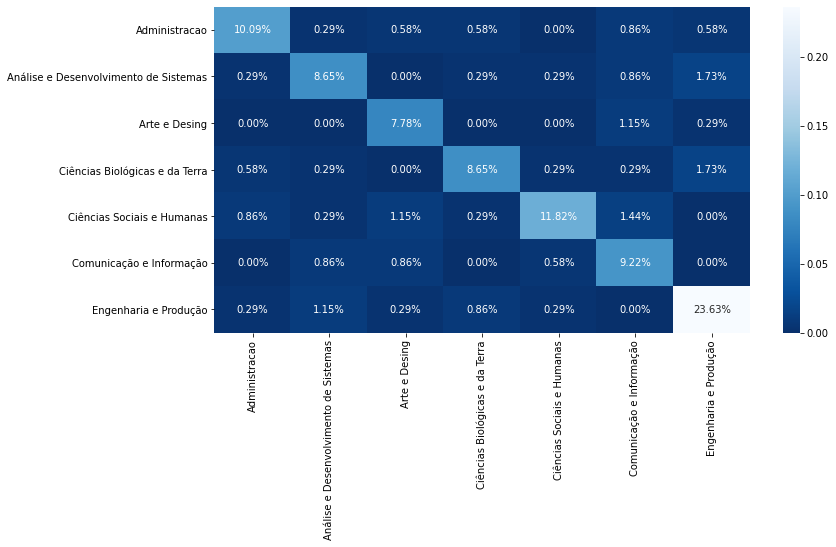

In [74]:
cm = confusion_matrix(y_test, clf.best_estimator_.predict(X_test_tf.toarray()))
# or
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues_r',
            xticklabels=le.classes_, yticklabels=le.classes_)

## Matriz de confusão aplicado a dados novos

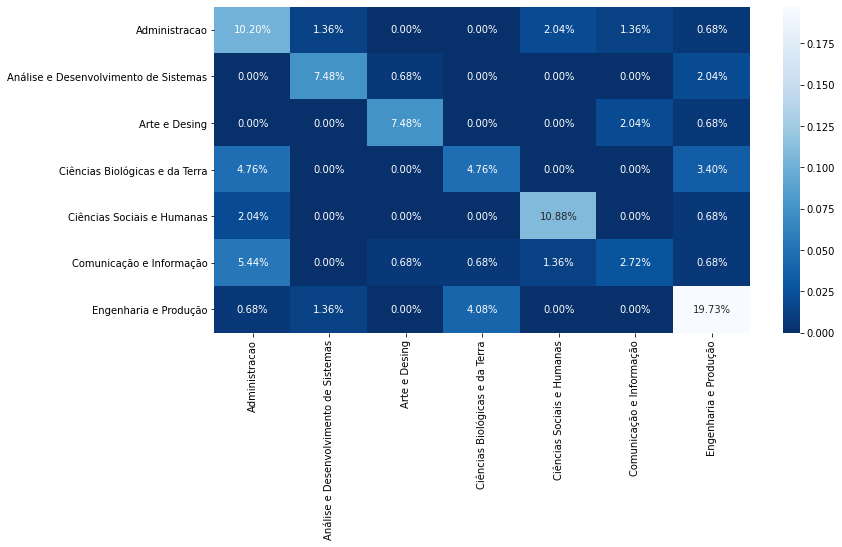

In [75]:
test = vectorizer.transform(df_test['text_stem'].values)
cm = confusion_matrix(df_test['target'].values, clf.best_estimator_.predict(test.toarray()))
# or
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues_r', 
            xticklabels=le.classes_, yticklabels=le.classes_)

In [76]:
clf.best_estimator_.predict(test.toarray())

array([0, 6, 0, 0, 5, 0, 4, 1, 4, 1, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0,
       0, 5, 2, 2, 2, 2, 2, 6, 2, 2, 5, 2, 2, 2, 2, 5, 6, 3, 0, 6, 0, 0,
       0, 0, 6, 6, 3, 3, 3, 3, 6, 3, 3, 0, 0, 6, 1, 1, 1, 1, 1, 1, 1, 1,
       6, 2, 6, 1, 1, 1, 6, 4, 4, 0, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 0, 0, 3, 5, 0, 4, 0, 2, 0, 6, 0, 5, 5, 0, 0, 6,
       6, 6, 6, 1, 6, 1, 6, 6, 6, 3, 6, 3, 6, 6, 6, 3, 3, 6, 3, 6, 6, 6,
       6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6])

In [77]:
prediction = clf.best_estimator_.predict(test.toarray())
for i in range(100):
  # print(df_test.loc[i, 'text'][:50], "...")
  print('Actual label:' + str(le.classes_[df_test.loc[i, 'target']]))
  print("Predicted label: " + str(le.classes_[prediction[i]]) + "\n") 

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Engenharia e Produção

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Comunicação e Informação

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Ciências Sociais e Humanas

Actual label:Administracao
Predicted label: Análise e Desenvolvimento de Sistemas

Actual label:Administracao
Predicted label: Ciências Sociais e Humanas

Actual label:Administracao
Predicted label: Análise e Desenvolvimento de Sistemas

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Ciências Sociais e Humanas

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Administracao

Actual label:Administracao
Predicted label: Administracao

Actual la